Introduction

In [106]:
#importing useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
#loading csv files from assigned data set: Patent Litigations
cases = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/cases.csv")
names = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/names.csv")

#loading external datasets:
pdl_companies = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/pdl_companies.csv")

<ipython-input-18-91c154eed40e>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  names = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/names.csv")


In [21]:
#isolating relevant variables from the raw data
cases = cases[['case_row_id', 'case_number', 'district_id', 'case_cause',
               'demand', 'date_filed', 'date_closed']]
names = names[['case_row_id', 'party_type', 'name_long']]

industry = pdl_companies[pdl_companies['country']=='united states']
industry = industry[['name', 'industry', 'locality', 'region']]

In [92]:
#merging the litigations files
merged_litigations = pd.merge(cases, names, on='case_row_id', how='inner')
print("There are" , merged_litigations['case_number'].nunique(),
      "unique cases in the data and", merged_litigations['name_long'].nunique(),
      "unique parties" )

There are 89411 unique cases in the data and 212495 unique parties


In [93]:
#cleaning the names variables in merged_litigations and companies_sorted to identify firms' industry
merged_litigations['normalized'] = merged_litigations['name_long'].str.strip().str.lower()
industry['normalized'] = industry['name'].str.strip().str.lower()

In [139]:
complete_merged = pd.merge(merged_litigations, industry, on='normalized', how='inner')
complete_merged

,case_row_id,case_number,district_id,case_cause,demand,date_filed,date_closed,party_type,name_long,normalized,name,industry,locality,region
0,86730.0,1:18-cv-00012,ared,35:271 Patent Infringement,NaN,2018-02-13,2018-07-06,Defendant,Eurark LLC,eurark llc,eurark llc,NaN,batesville,arkansas
1,30787.0,2:99-cv-00674,azd,15:1125 Trademark Infringement (Lanham Act),$0.00,1999-04-09,1999-12-16,Plaintiff,Star Video Duplicating,star video duplicating,star video duplicating,motion pictures and film,NaN,arizona
2,15182.0,1:08-cv-01405,dcd,35:145 Patent Infringement,NaN,2008-08-13,2008-11-12,Defendant,SANYO NORTH AMERICA CORPORATION,sanyo north america corporation,sanyo north america corporation,NaN,san diego,california
3,60752.0,4:01-cv-80235,iasd,35:271 Patent Infringement,$0.00,2001-04-16,2001-08-13,Defendant,"Platinum Performance, Inc.","platinum performance, inc.","platinum performance, inc.",NaN,buellton,california
4,60752.0,4:01-cv-80235,iasd,35:271 Patent Infringement,$0.00,2001-04-16,2001-08-13,Defendant,"Platinum Performance, Inc.","platinum performance, inc.","platinum performance, inc.","health, wellness and fitness",buellton,california
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49578,37186.0,2:08-cv-00045,wyd,35:271 Patent Infringement,NaN,2008-02-19,2009-07-20,Counter Claimant,Cables Unlimited,cables unlimited,cables unlimited,consumer electronics,concord,california
49579,37186.0,2:08-cv-00045,wyd,35:271 Patent Infringement,NaN,2008-02-19,2009-07-20,Counter Claimant,Cables Unlimited,cables unlimited,cables unlimited,electrical/electronic manufacturing,yaphank,new york
49580,37186.0,2:08-cv-00045,wyd,35:271 Patent Infringement,NaN,2008-02-19,2009-07-20,Defendant,Cables Unlimited,cables unlimited,cables unlimited,consumer electronics,concord,california
49581,37186.0,2:08-cv-00045,wyd,35:271 Patent Infringement,NaN,2008-02-19,2009-07-20,Defendant,Cables Unlimited,cables unlimited,cables unlimited,electrical/electronic manufacturing,yaphank,new york


In [140]:
complete_merged['year'] = complete_merged['date_closed'].str[0:4].astype(float)
complete_merged.head()

,case_row_id,case_number,district_id,case_cause,demand,date_filed,date_closed,party_type,name_long,normalized,name,industry,locality,region,year
0,86730.0,1:18-cv-00012,ared,35:271 Patent Infringement,NaN,2018-02-13,2018-07-06,Defendant,Eurark LLC,eurark llc,eurark llc,NaN,batesville,arkansas,2018.0
1,30787.0,2:99-cv-00674,azd,15:1125 Trademark Infringement (Lanham Act),$0.00,1999-04-09,1999-12-16,Plaintiff,Star Video Duplicating,star video duplicating,star video duplicating,motion pictures and film,NaN,arizona,1999.0
2,15182.0,1:08-cv-01405,dcd,35:145 Patent Infringement,NaN,2008-08-13,2008-11-12,Defendant,SANYO NORTH AMERICA CORPORATION,sanyo north america corporation,sanyo north america corporation,NaN,san diego,california,2008.0
3,60752.0,4:01-cv-80235,iasd,35:271 Patent Infringement,$0.00,2001-04-16,2001-08-13,Defendant,"Platinum Performance, Inc.","platinum performance, inc.","platinum performance, inc.",NaN,buellton,california,2001.0
4,60752.0,4:01-cv-80235,iasd,35:271 Patent Infringement,$0.00,2001-04-16,2001-08-13,Defendant,"Platinum Performance, Inc.","platinum performance, inc.","platinum performance, inc.","health, wellness and fitness",buellton,california,2001.0


In [150]:
poverty_dataset = poverty_dataset[poverty_dataset['country'] == 'United States']

In [159]:
poverty = poverty_dataset[['year','gini', 'polarization', 'palma_ratio']]
poverty['year'] = poverty['year'].astype(float)
poverty

<ipython-input-159-9b5e490c1435>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty['year'] = poverty['year'].astype(float)


,year,gini,polarization,palma_ratio
2304,1974.0,0.353435,0.306144,1.425602
2305,1979.0,0.345002,0.302239,1.360074
2306,1986.0,0.373515,0.338649,1.582471
2307,1991.0,0.380459,0.338339,1.654780
2308,1992.0,0.383739,0.342013,1.683200
...,...,...,...,...
4769,2015.0,0.412388,0.369324,1.958059
4770,2016.0,0.411219,0.365504,1.956331
4771,2017.0,0.411806,0.370406,1.965033
4772,2018.0,0.414078,0.366918,1.993973


In [160]:
merged_litigations['year'] = merged_litigations['date_closed'].str[0:4].astype(float)
litigations_gini_merged = merged_litigations.merge(poverty, on='year', how='inner')
litigations_gini_merged

,case_row_id,case_number,district_id,case_cause,demand,date_filed,date_closed,party_type,name_long,normalized,year,gini,polarization,palma_ratio
0,75332.0,2:10-cv-00601,almd,15:1126 Patent Infringement,NaN,2010-07-14,2010-10-12,Defendant,Johnson & Johnson Inc.,johnson & johnson inc.,2010.0,0.400107,0.357794,1.840191
1,75332.0,2:10-cv-00601,almd,15:1126 Patent Infringement,NaN,2010-07-14,2010-10-12,Defendant,Johnson & Johnson Inc.,johnson & johnson inc.,2010.0,0.400107,0.357794,1.840191
2,75332.0,2:10-cv-00601,almd,15:1126 Patent Infringement,NaN,2010-07-14,2010-10-12,Defendant,McNeil-PPC. Inc.,mcneil-ppc. inc.,2010.0,0.400107,0.357794,1.840191
3,75332.0,2:10-cv-00601,almd,15:1126 Patent Infringement,NaN,2010-07-14,2010-10-12,Defendant,McNeil-PPC. Inc.,mcneil-ppc. inc.,2010.0,0.400107,0.357794,1.840191
4,75332.0,2:10-cv-00601,almd,15:1126 Patent Infringement,NaN,2010-07-14,2010-10-12,Plaintiff,William E. Bowhall,william e. bowhall,2010.0,0.400107,0.357794,1.840191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024465,13232.0,1:06-cv-00164,wyd,35:271 Patent Infringement,NaN,2006-06-27,2007-05-14,Defendant,Benz Silent Rider a corporation,benz silent rider a corporation,2007.0,0.407986,0.350755,1.931840
1024466,13232.0,1:06-cv-00164,wyd,35:271 Patent Infringement,NaN,2006-06-27,2007-05-14,Defendant,Willard B Turner an individual,willard b turner an individual,2007.0,0.407986,0.350755,1.931840
1024467,13232.0,1:06-cv-00164,wyd,35:271 Patent Infringement,NaN,2006-06-27,2007-05-14,Defendant,Willard B Turner an individual,willard b turner an individual,2007.0,0.407986,0.350755,1.931840
1024468,13232.0,1:06-cv-00164,wyd,35:271 Patent Infringement,NaN,2006-06-27,2007-05-14,Plaintiff,Mountain West Motorsports Inc a corporation,mountain west motorsports inc a corporation,2007.0,0.407986,0.350755,1.931840


In [153]:
litigations_gini_merged.reset_index()

,index,case_row_id,case_number,district_id,case_cause,demand,date_filed,date_closed,party_type,name_long,normalized,year,gini,polarization
0,0,75332.0,2:10-cv-00601,almd,15:1126 Patent Infringement,NaN,2010-07-14,2010-10-12,Defendant,Johnson & Johnson Inc.,johnson & johnson inc.,2010.0,0.400107,0.357794
1,1,75332.0,2:10-cv-00601,almd,15:1126 Patent Infringement,NaN,2010-07-14,2010-10-12,Defendant,Johnson & Johnson Inc.,johnson & johnson inc.,2010.0,0.400107,0.357794
2,2,75332.0,2:10-cv-00601,almd,15:1126 Patent Infringement,NaN,2010-07-14,2010-10-12,Defendant,McNeil-PPC. Inc.,mcneil-ppc. inc.,2010.0,0.400107,0.357794
3,3,75332.0,2:10-cv-00601,almd,15:1126 Patent Infringement,NaN,2010-07-14,2010-10-12,Defendant,McNeil-PPC. Inc.,mcneil-ppc. inc.,2010.0,0.400107,0.357794
4,4,75332.0,2:10-cv-00601,almd,15:1126 Patent Infringement,NaN,2010-07-14,2010-10-12,Plaintiff,William E. Bowhall,william e. bowhall,2010.0,0.400107,0.357794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024465,1024465,13232.0,1:06-cv-00164,wyd,35:271 Patent Infringement,NaN,2006-06-27,2007-05-14,Defendant,Benz Silent Rider a corporation,benz silent rider a corporation,2007.0,0.407986,0.350755
1024466,1024466,13232.0,1:06-cv-00164,wyd,35:271 Patent Infringement,NaN,2006-06-27,2007-05-14,Defendant,Willard B Turner an individual,willard b turner an individual,2007.0,0.407986,0.350755
1024467,1024467,13232.0,1:06-cv-00164,wyd,35:271 Patent Infringement,NaN,2006-06-27,2007-05-14,Defendant,Willard B Turner an individual,willard b turner an individual,2007.0,0.407986,0.350755
1024468,1024468,13232.0,1:06-cv-00164,wyd,35:271 Patent Infringement,NaN,2006-06-27,2007-05-14,Plaintiff,Mountain West Motorsports Inc a corporation,mountain west motorsports inc a corporation,2007.0,0.407986,0.350755


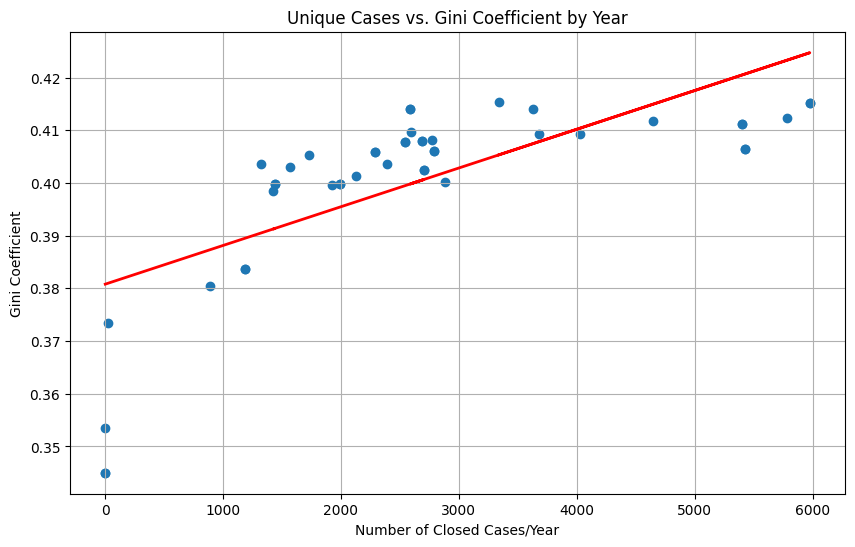

In [154]:
# Step 1: Aggregate unique case_numbers per year
unique_cases_per_year = (
    litigations_gini_merged.groupby('year')['case_number']
    .nunique()
    .reset_index(name='unique_cases')
)


# Step 2: Keep `year` and `gini` columns for merging
gini_data = litigations_gini_merged[['year', 'gini']].drop_duplicates()

# Merge unique cases with gini values
plot_data = unique_cases_per_year.merge(gini_data, on='year')

# Step 3: Scatter plot with trend line
x = plot_data['unique_cases']
y = plot_data['gini']
coefficients = np.polyfit(x, y, 1)
trend_line = np.poly1d(coefficients)
plt.figure(figsize=(10, 6))
plt.scatter(plot_data['unique_cases'], plot_data['gini'], marker='o')
plt.plot(x, trend_line(x), color='red', linewidth=2, label='Trend Line')
plt.title('Unique Cases vs. Gini Coefficient by Year')
plt.xlabel('Number of Closed Cases/Year')
plt.ylabel('Gini Coefficient')
plt.grid(True)
plt.show()

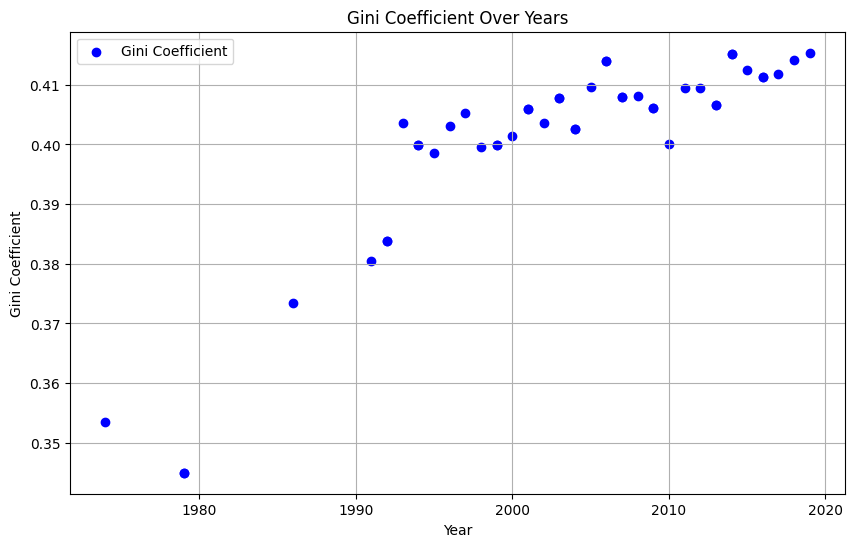

In [148]:
plt.figure(figsize=(10, 6))
plt.scatter(gini_data['year'], gini_data['gini'], marker='o', color='blue', label='Gini Coefficient')

plt.title('Gini Coefficient Over Years')
plt.xlabel('Year')
plt.ylabel('Gini Coefficient')
plt.grid(True)
plt.legend()
plt.show()

In [121]:
poverty_dataset

,country,year,reporting_level,welfare_type,ppp_version,survey_year,survey_comparability,headcount_ratio_international_povline,headcount_ratio_lower_mid_income_povline,headcount_ratio_upper_mid_income_povline,...,decile8_thr,decile9_thr,gini,mld,polarization,palma_ratio,s80_s20_ratio,p90_p10_ratio,p90_p50_ratio,p50_p10_ratio
2304,United States,1974,national,income,2011,1974.0,0.0,0.494083,0.999972,1.744925,...,62.75,81.5,0.353435,0.247521,0.306144,1.425602,6.699552,5.397351,2.173333,2.483444
2305,United States,1979,national,income,2011,1979.0,0.0,0.499158,0.749623,1.247826,...,68.20,89.0,0.345002,0.229293,0.302239,1.360074,6.316897,5.297619,2.160194,2.452381
2306,United States,1986,national,income,2011,1986.0,0.0,0.498988,0.749410,1.248677,...,75.00,98.7,0.373515,0.269394,0.338649,1.582471,7.657083,6.476378,2.308772,2.805118
2307,United States,1991,national,income,2011,1991.0,0.0,0.499387,0.749145,1.245133,...,75.90,100.2,0.380459,0.273879,0.338339,1.654780,7.864268,6.423077,2.303448,2.788462
2308,United States,1992,national,income,2011,1992.0,0.0,0.497899,0.749928,1.494455,...,75.95,101.3,0.383739,0.280101,0.342013,1.683200,8.044442,6.595052,2.342197,2.815755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4769,United States,2015,national,income,2017,2015.0,1.0,1.249188,1.249188,2.248539,...,101.70,138.9,0.412388,0.328297,0.369324,1.958059,8.884385,6.652299,2.562731,2.595785
4770,United States,2016,national,income,2017,2016.0,1.0,0.999391,1.247934,1.997358,...,105.90,143.9,0.411219,0.326951,0.365504,1.956331,8.923177,6.655874,2.502609,2.659574
4771,United States,2017,national,income,2017,2017.0,1.0,1.249923,1.499683,1.996694,...,107.00,147.2,0.411806,0.336453,0.370406,1.965033,9.023461,6.872082,2.524871,2.721755
4772,United States,2018,national,income,2017,2018.0,1.0,0.999792,1.249539,1.749701,...,111.90,153.3,0.414078,0.331134,0.366918,1.993973,9.070496,6.747359,2.513115,2.684859
